In [1]:
# pip install tensorflow numpy matplotlib opencv-python scikit-learn
# installing all the libraries i might use 
#importing the libraries 
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image


In [2]:
#loading the data 
DATA_DIR = r'C:\Users\91947\Desktop\dataset\OS_Collected_Data'

classes = os.listdir(DATA_DIR)
print("Classes found:", classes)

Classes found: ['Normal', 'Osteopenia', 'Osteoporosis']


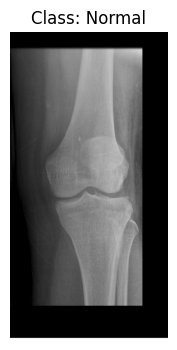

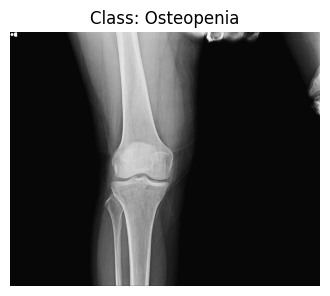

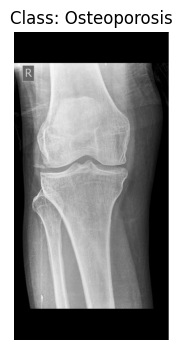

In [3]:
#visualizing the image
import matplotlib.pyplot as plt
import cv2

for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    image_files = os.listdir(cls_path)
    if image_files:
        img_path = os.path.join(cls_path, image_files[0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Class: {cls}")
        plt.axis('off')
        plt.show()


In [4]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Set your dataset directory
DATA_DIR = r'C:\Users\91947\Desktop\dataset\OS_Collected_Data'

# Define target image size and batch size
img_size = (224, 224)
batch_size = 32

# Create an ImageDataGenerator instance with data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=20,         # Random rotations in degrees
    width_shift_range=0.2,     # Random horizontal shifts
    height_shift_range=0.2,    # Random vertical shifts
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Random horizontal flips
    validation_split=0.2       # Reserve 20% of data for validation
)

# Create training data generator
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Optionally, print class indices to verify
print("Class indices:", train_generator.class_indices)

# ---------------------------
# Now, Build Your Model
# ---------------------------

# 1. Load the pre-trained ResNet50 model without the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Build the custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# Apply Dropout with a specified seed (this line now works because x is defined)
x = Dropout(0.5, seed=42)(x)

# 3. Determine the number of classes from your data generator and add the final Dense layer
num_classes = len(train_generator.class_indices)
predictions = Dense(num_classes, activation='softmax')(x)

# 4. Combine the base model and the new top layers into a final model
model = Model(inputs=base_model.input, outputs=predictions)

# Now you can continue with compiling and training your model...



Found 1559 images belonging to 3 classes.
Found 388 images belonging to 3 classes.
Class indices: {'Normal': 0, 'Osteopenia': 1, 'Osteoporosis': 2}


In [5]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ----- Data Generators Setup (Assuming these are already defined) -----
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set your dataset directory
DATA_DIR = r'C:\Users\91947\Desktop\dataset\OS_Collected_Data'

# Define target image size and batch size
img_size = (224, 224)
batch_size = 32

# Create an ImageDataGenerator instance with augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=20,         # Random rotations in degrees
    width_shift_range=0.2,     # Random horizontal shifts
    height_shift_range=0.2,    # Random vertical shifts
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Random horizontal flips
    validation_split=0.2       # Reserve 20% for validation
)

# Create training data generator
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Optionally, print class indices to verify
print("Class indices:", train_generator.class_indices)

# ----- Model Building and Training -----
model_path = "osteoporosis_detector.h5"

if os.path.exists(model_path):
    # Load the previously trained model
    model = load_model(model_path)
    print("Loaded saved model from", model_path)
else:
    # Build the model using transfer learning with ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Add custom layers on top of the base model for your classification task
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # You can also specify a seed here if needed, e.g., Dropout(0.5, seed=42)
    
    # Determine the number of classes from your data generator
    num_classes = len(train_generator.class_indices)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Combine the base model with the new layers
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the base model layers so that only the new layers are trained initially
    for layer in base_model.layers:
        layer.trainable = False
    
    # Compile the model with an appropriate optimizer and loss function
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Set up EarlyStopping callback to halt training if validation loss does not improve
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model using the training and validation generators
    history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping],
    )
    
    # Save the trained model to disk for later use
    model.save(model_path)
    print("Model saved to", model_path)

# ----- Visualize Training Status (Only available if the model was trained in this session) -----
# If you just loaded the model, you might not have training history.
if 'history' in locals():
    plt.figure(figsize=(10, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], marker='o', label='Train Loss')
    plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
else:
    print("No training history available since the model was loaded from disk.")


Found 1559 images belonging to 3 classes.
Found 388 images belonging to 3 classes.
Class indices: {'Normal': 0, 'Osteopenia': 1, 'Osteoporosis': 2}


Loaded saved model from osteoporosis_detector.h5
No training history available since the model was loaded from disk.


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test dataset directory
TEST_DIR = r'C:\Users\91947\Desktop\dataset\Process\test'  # Update this path if needed

# Image parameters (must match those used during training)
img_size = (224, 224)  # Change this if you used a different size
batch_size = 90        # Adjust batch size as per your system's capability

# Create a test data generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test images
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False  # No shuffling for evaluation purposes
)

# Print class indices (useful for interpretation)
print("Class Indices:", test_generator.class_indices)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Found 9 images belonging to 3 classes.
Class Indices: {'normal': 0, 'osteopenia': 1, 'osteoporosis': 2}
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5556 - loss: 1.0045
Test Loss: 1.0045
Test Accuracy: 0.5556


In [17]:
import numpy as np

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get actual class labels
true_classes = test_generator.classes

# Print some sample results
for i in range(5):  # Print first 5 predictions
    print(f"Actual: {true_classes[i]}, Predicted: {predicted_classes[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Actual: 0, Predicted: 2
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 2
Actual: 1, Predicted: 2


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)


Confusion Matrix:
 [[2 0 1]
 [0 0 3]
 [0 0 3]]
Classification Report:
               precision    recall  f1-score   support

      normal       1.00      0.67      0.80         3
  osteopenia       0.00      0.00      0.00         3
osteoporosis       0.43      1.00      0.60         3

    accuracy                           0.56         9
   macro avg       0.48      0.56      0.47         9
weighted avg       0.48      0.56      0.47         9



C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
